# Load package

In [1]:
#!pip install analysis-tools
#!pip install tabulate missingno

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from analysis_tools.common import *

# 1. Load dataset

In [3]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True, data_home='.')
data = pd.concat([X, y], axis='columns')
target = 'survived'

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  survived   1309 non-null   category
dtypes: category(3), float64(6), object(5)
memory usage: 116.8+ KB


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.00,"Allen, Miss. Elisabeth Walton",female,29.00,0.00,0.00,24160,211.34,B5,S,2,NaN,"St Louis, MO",1
1,1.00,"Allison, Master. Hudson Trevor",male,0.92,1.00,2.00,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.00,"Allison, Miss. Helen Loraine",female,2.00,1.00,2.00,113781,151.55,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.00,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1.00,2.00,113781,151.55,C22 C26,S,None,135.00,"Montreal, PQ / Chesterville, ON",0
4,1.00,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1.00,2.00,113781,151.55,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


In [5]:
vis_dir = 'visualization'
os.makedirs(vis_dir, exist_ok=True)

# 2. Set dtypes
- Numerical features: `float32`
- Categorical features: `category` or `string`

In [6]:
num_features = ['age', 'sibsp', 'parch', 'fare']
cat_features = data.columns.drop(num_features)

data[num_features] = data[num_features].astype('float32')
data[cat_features] = data[cat_features].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   category
 1   name       1309 non-null   category
 2   sex        1309 non-null   category
 3   age        1046 non-null   float32 
 4   sibsp      1309 non-null   float32 
 5   parch      1309 non-null   float32 
 6   ticket     1309 non-null   category
 7   fare       1308 non-null   float32 
 8   cabin      295 non-null    category
 9   embarked   1307 non-null   category
 10  boat       486 non-null    category
 11  body       121 non-null    category
 12  home.dest  745 non-null    category
 13  survived   1309 non-null   category
dtypes: category(10), float32(4)
memory usage: 143.8 KB


# 3. Explatory Data Analysis

In [7]:
from analysis_tools import eda

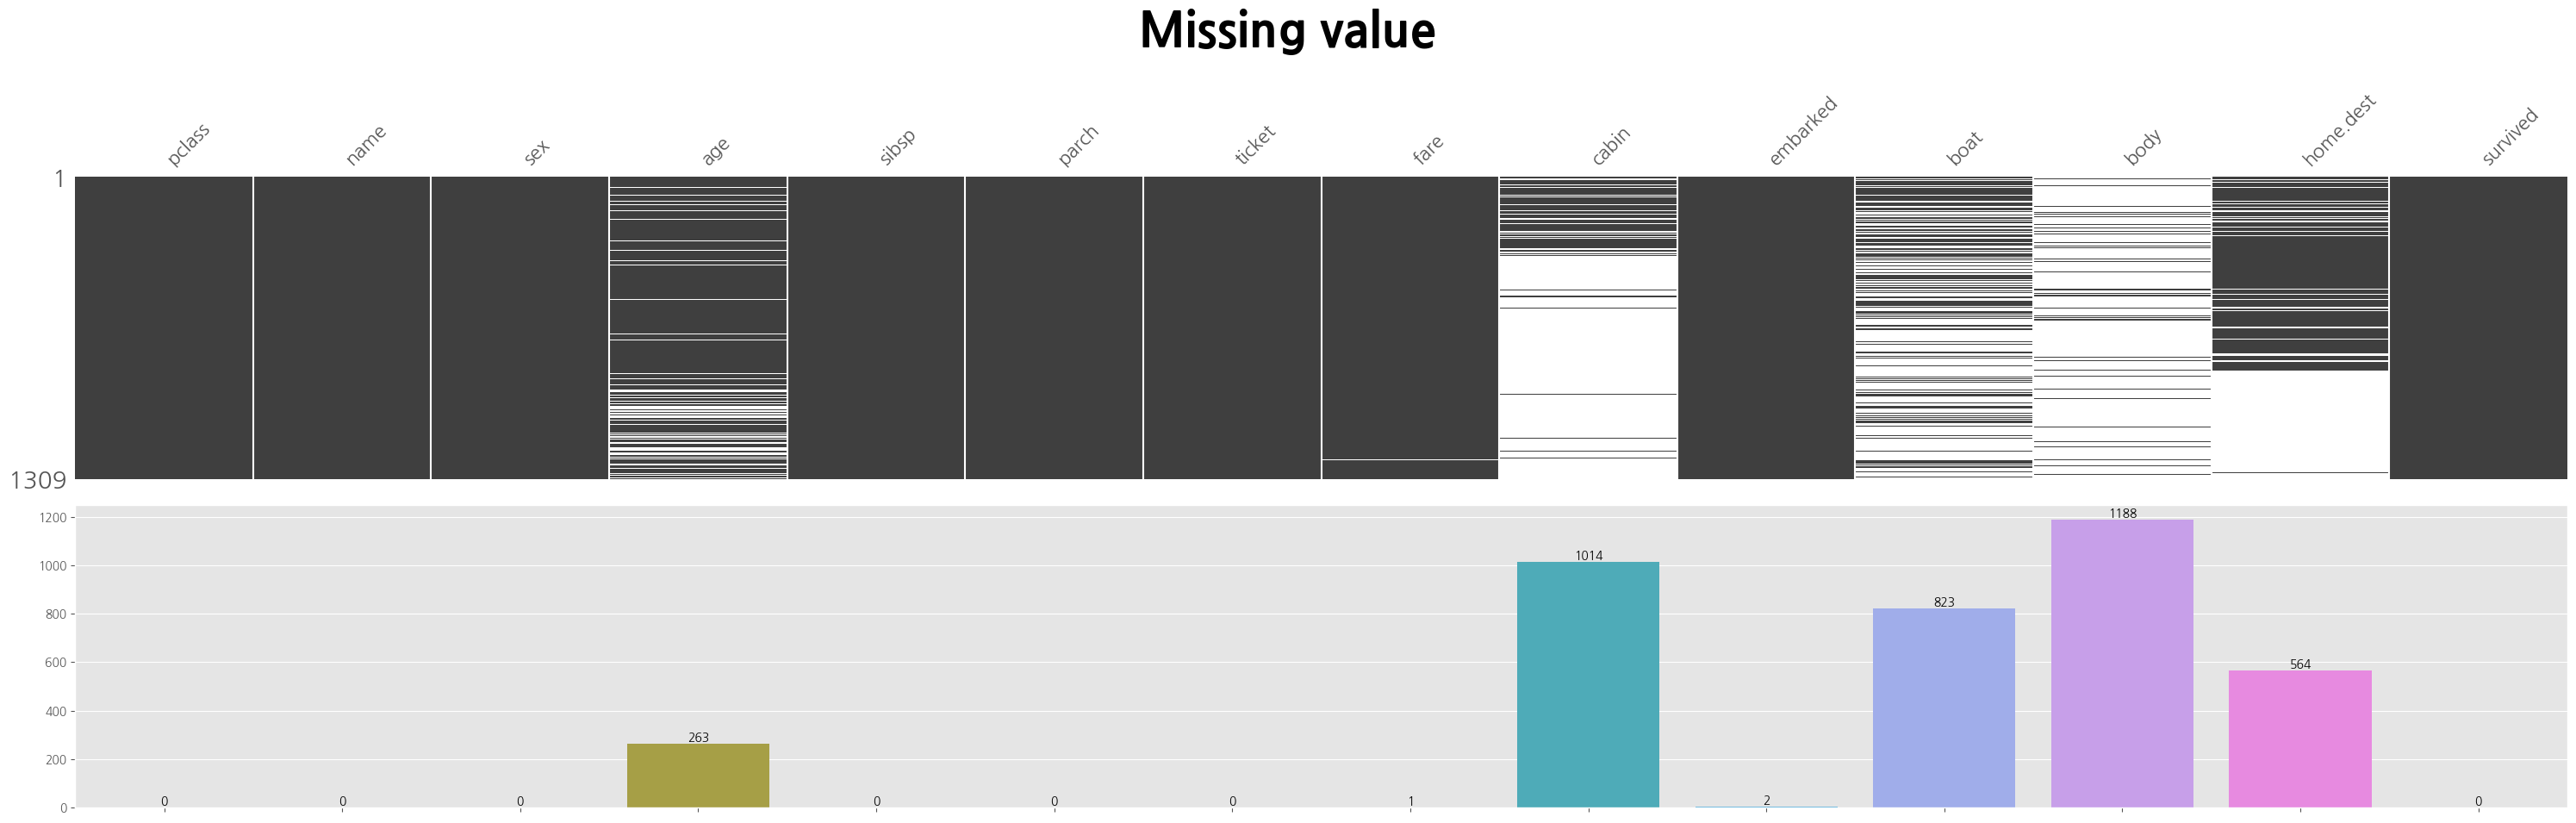

In [8]:
eda.plot_missing_value(data, save_dir=vis_dir)

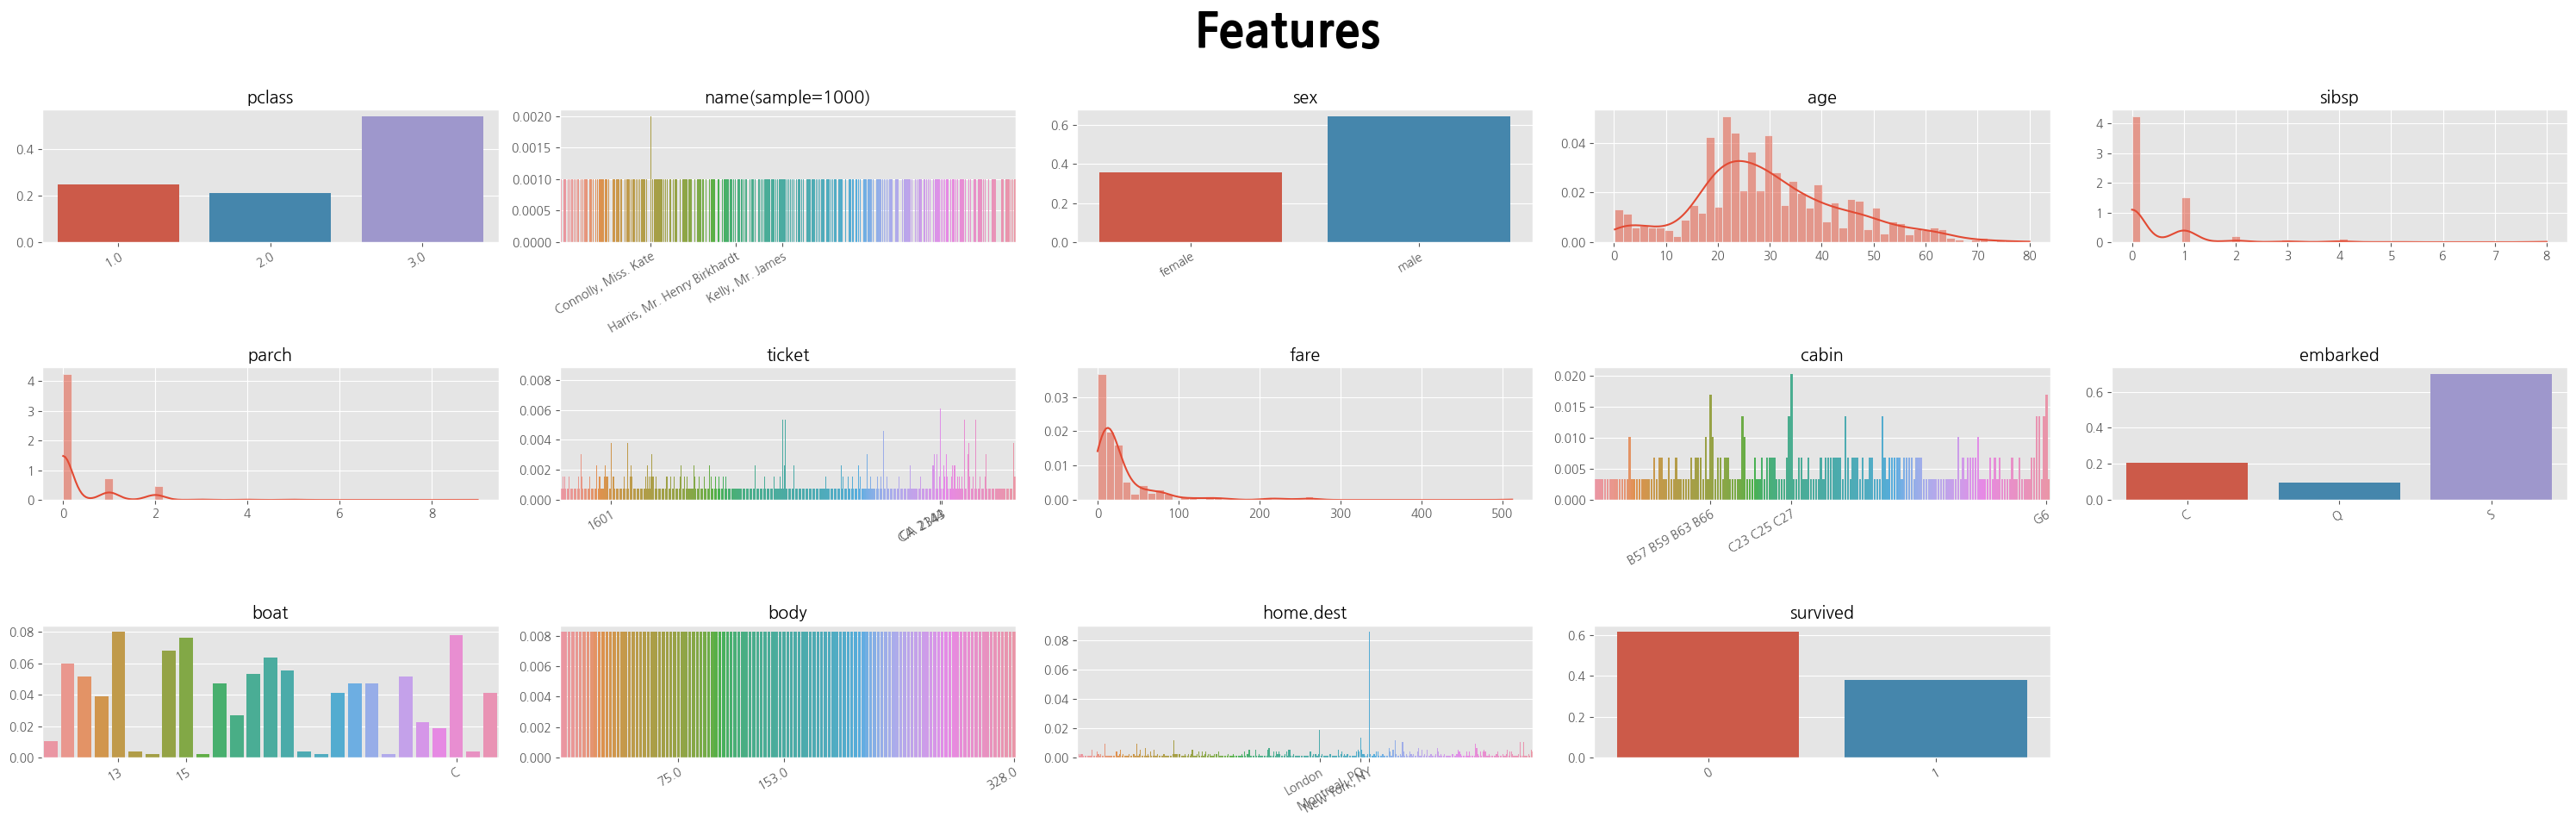

In [9]:
eda.plot_features(data, n_classes=3, save_dir=vis_dir)

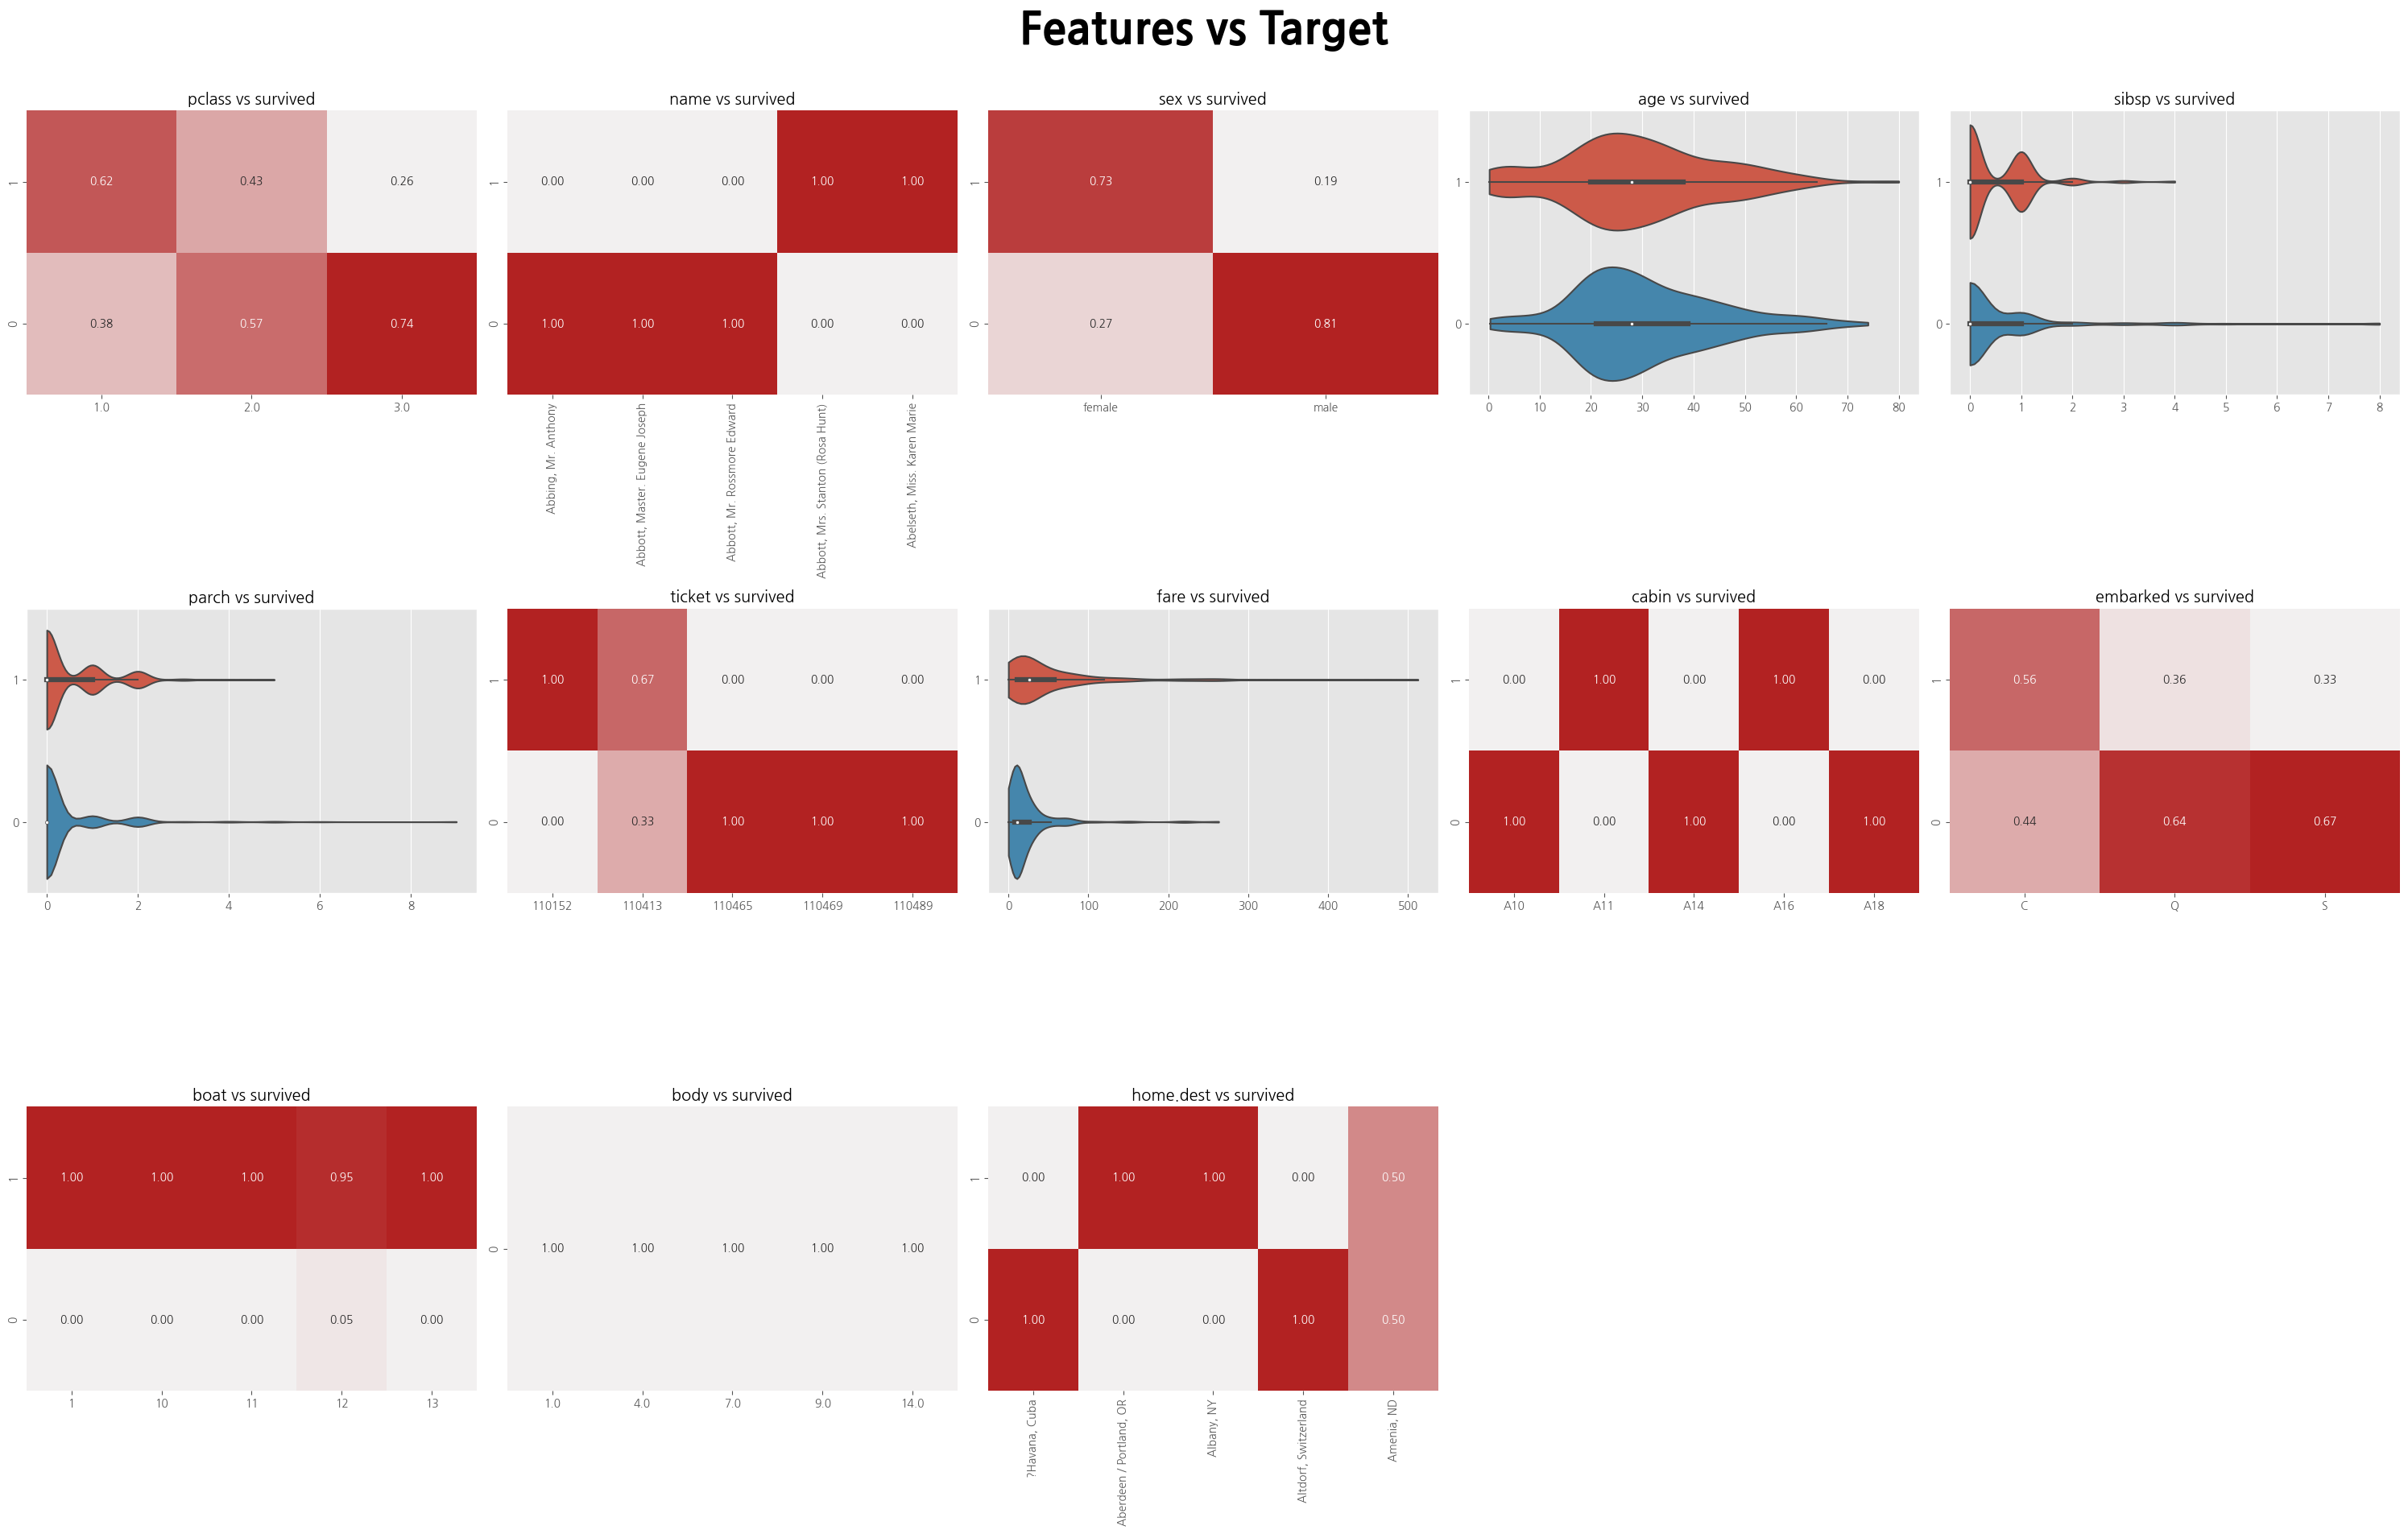

In [10]:
eda.plot_features_target(data, target, figsize=(30, 20), save_dir=vis_dir)

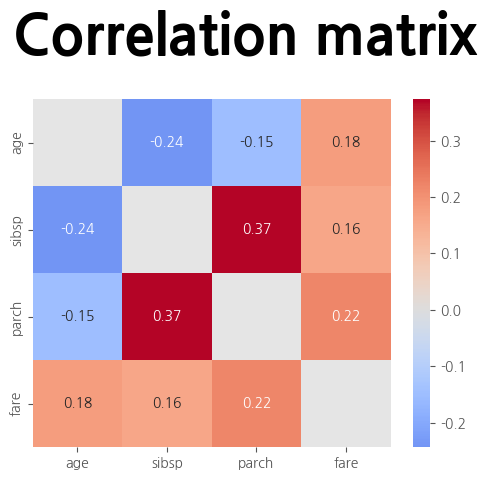

In [11]:
eda.plot_corr(data.corr(), mask=False, figsize=(5, 5), save_dir=vis_dir)

# 4. Preprocessing

In [12]:
from sklearn.impute import SimpleImputer

data_proc = copy(data)
data_proc.drop(columns=['body', 'boat'], inplace=True)  # inferred by target

data_proc.drop(columns=['name', 'home.dest', 'ticket'], inplace=True)  # too sparse features
imputer = SimpleImputer(strategy='median')
data_proc['age'] = imputer.fit_transform(data_proc[['age']])

data_proc['cabin'] = data_proc['cabin'].str.extract(r".*([A-Z]).*").fillna('other')
min_fare = sorted(data_proc['fare'].unique())[1]
data_proc['fare'] = data_proc['fare'].map(lambda x: max(x, min_fare)).map(np.log)

cat_features = ['sex', 'cabin', 'embarked']
data_proc = data_proc.drop(columns=cat_features).join(pd.concat([pd.get_dummies(data_proc[f], prefix=f) for f in cat_features], axis=1))

data_proc.dropna(inplace=True)
data_proc = data_proc.astype('float32')

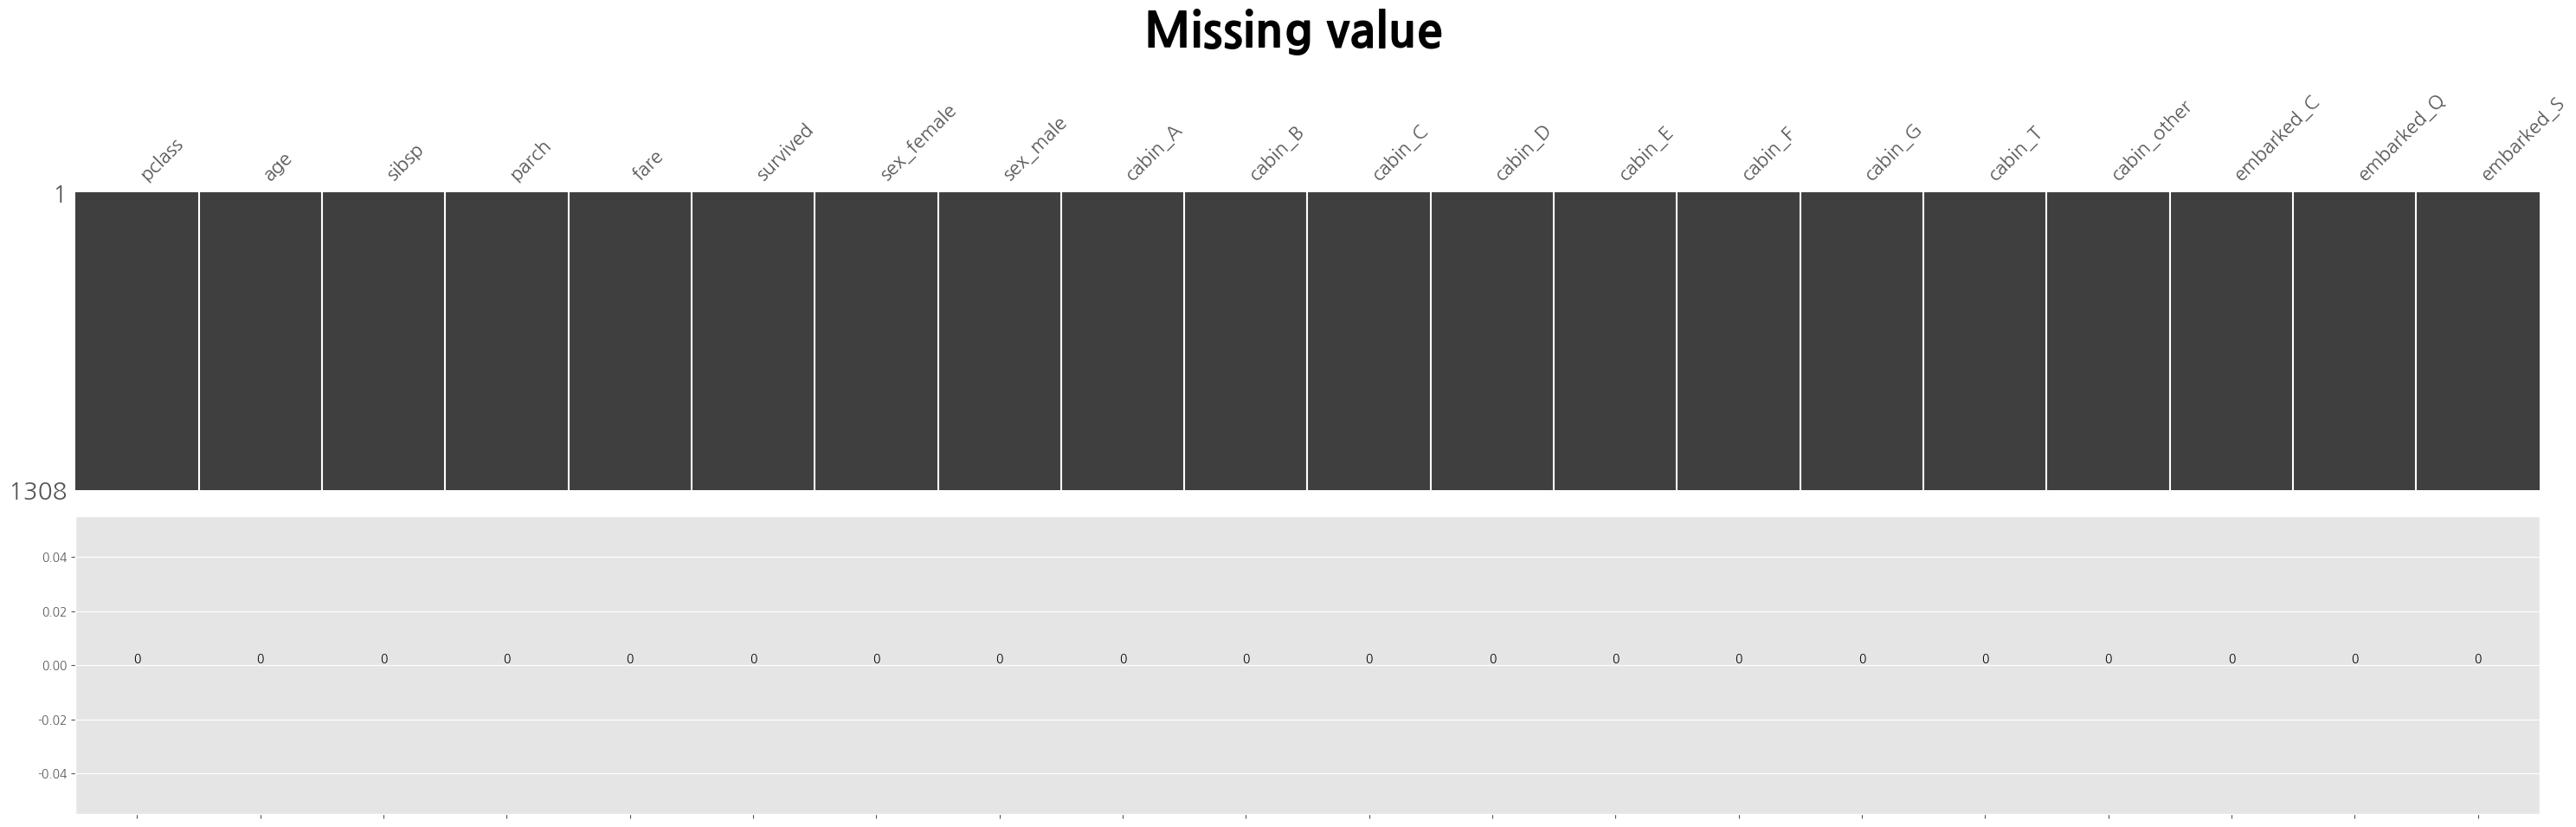

In [13]:
eda.plot_missing_value(data_proc, save_dir=vis_dir)

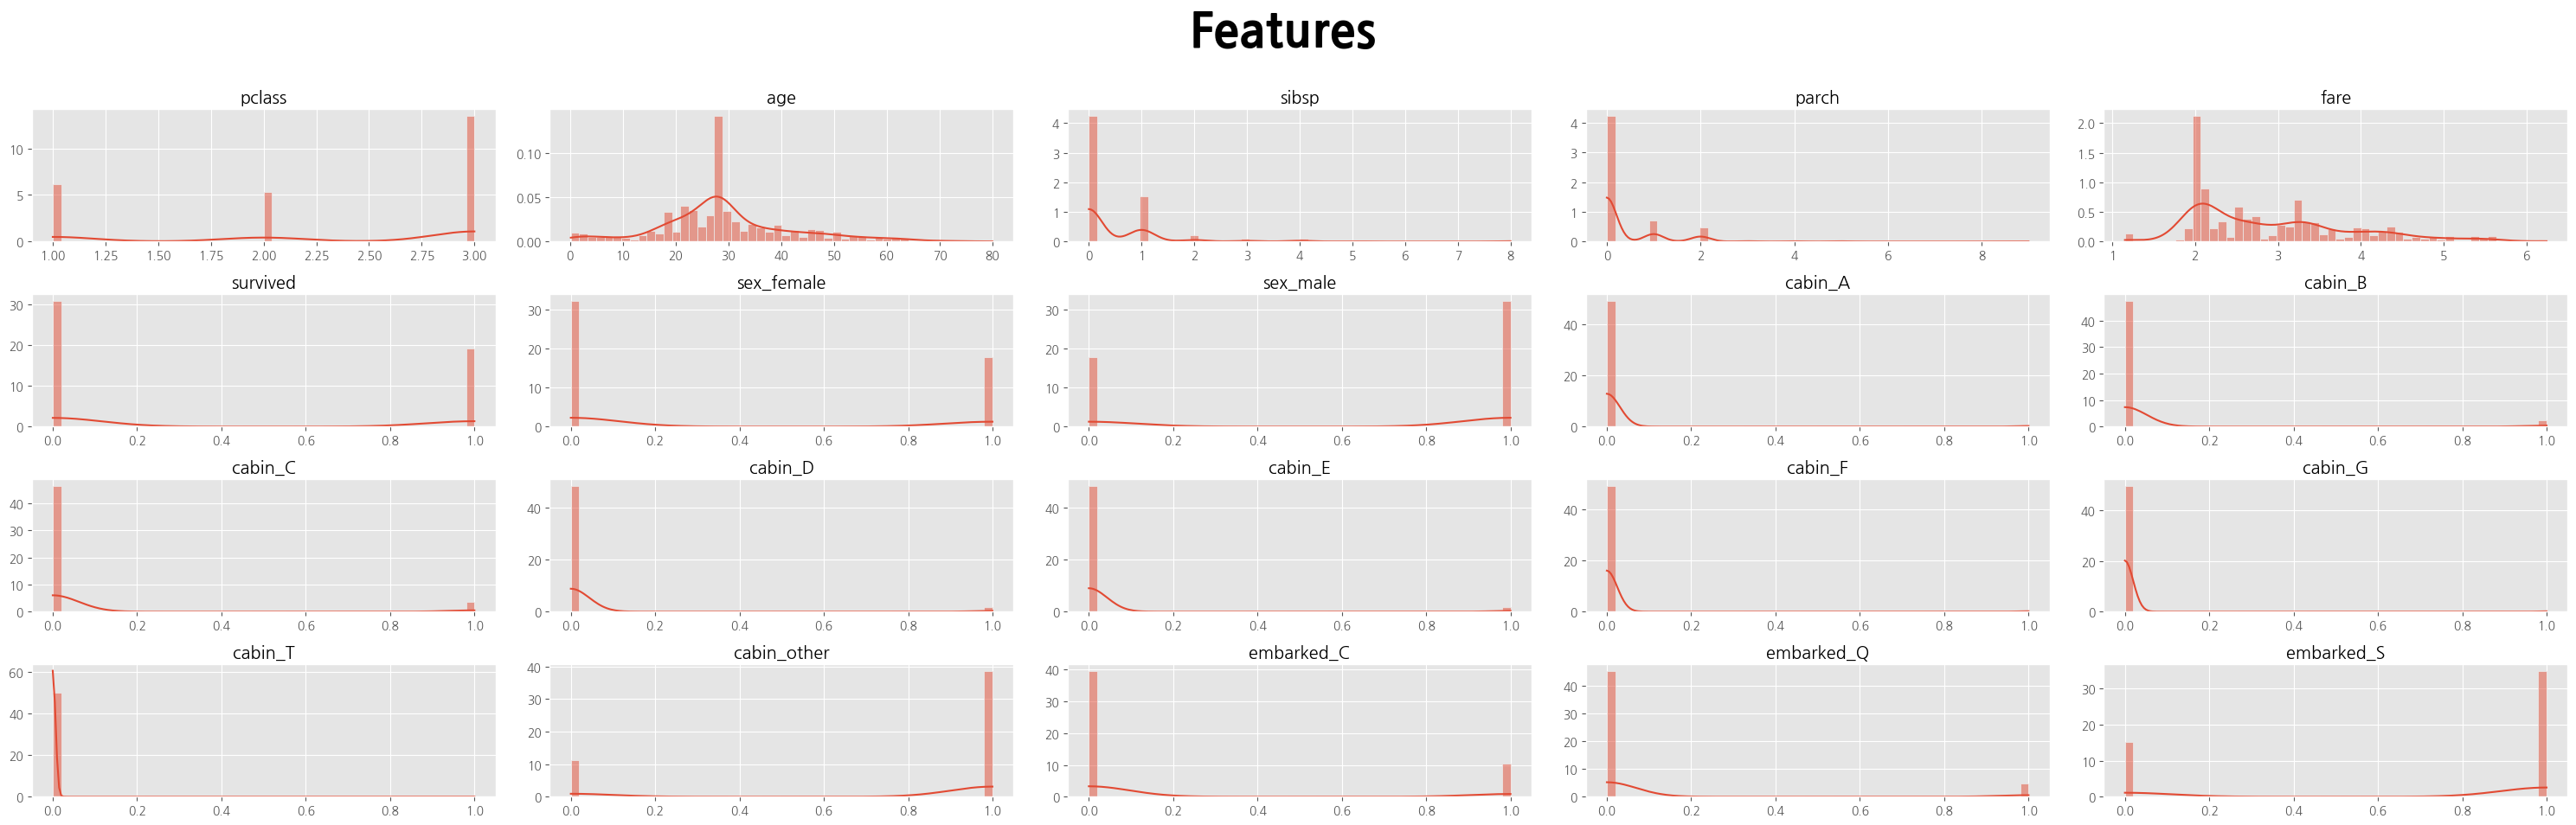

In [14]:
eda.plot_features(data_proc, save_dir=vis_dir)

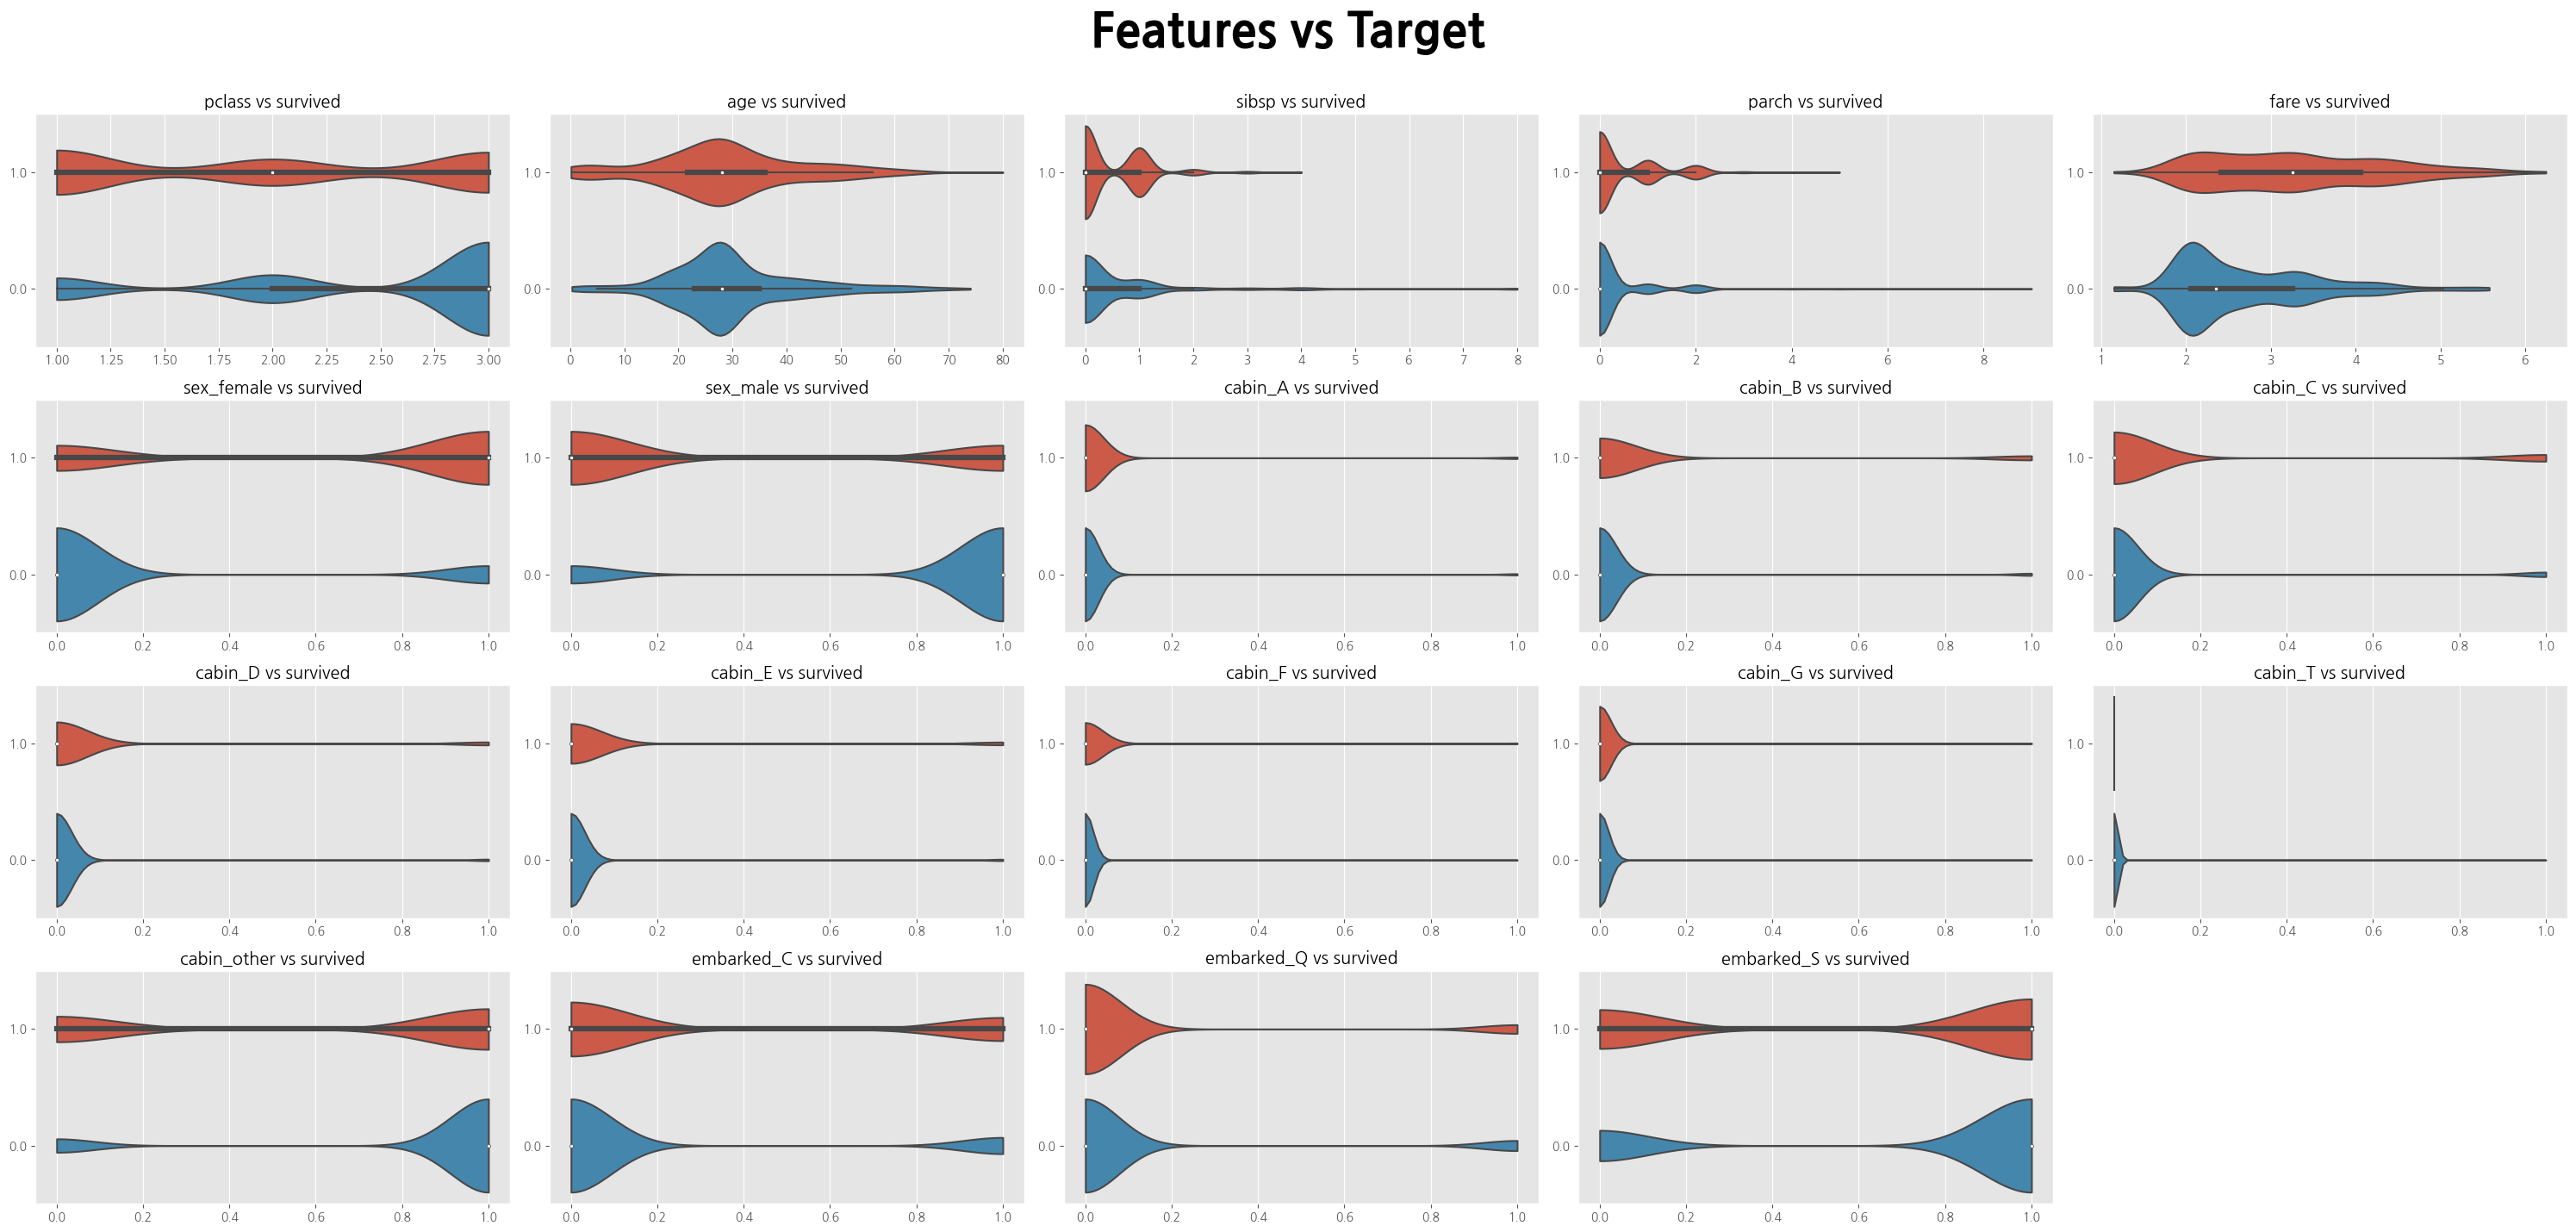

In [15]:
eda.plot_features_target(data_proc, target, target_type='cat', figsize=(30, 15), save_dir=vis_dir)

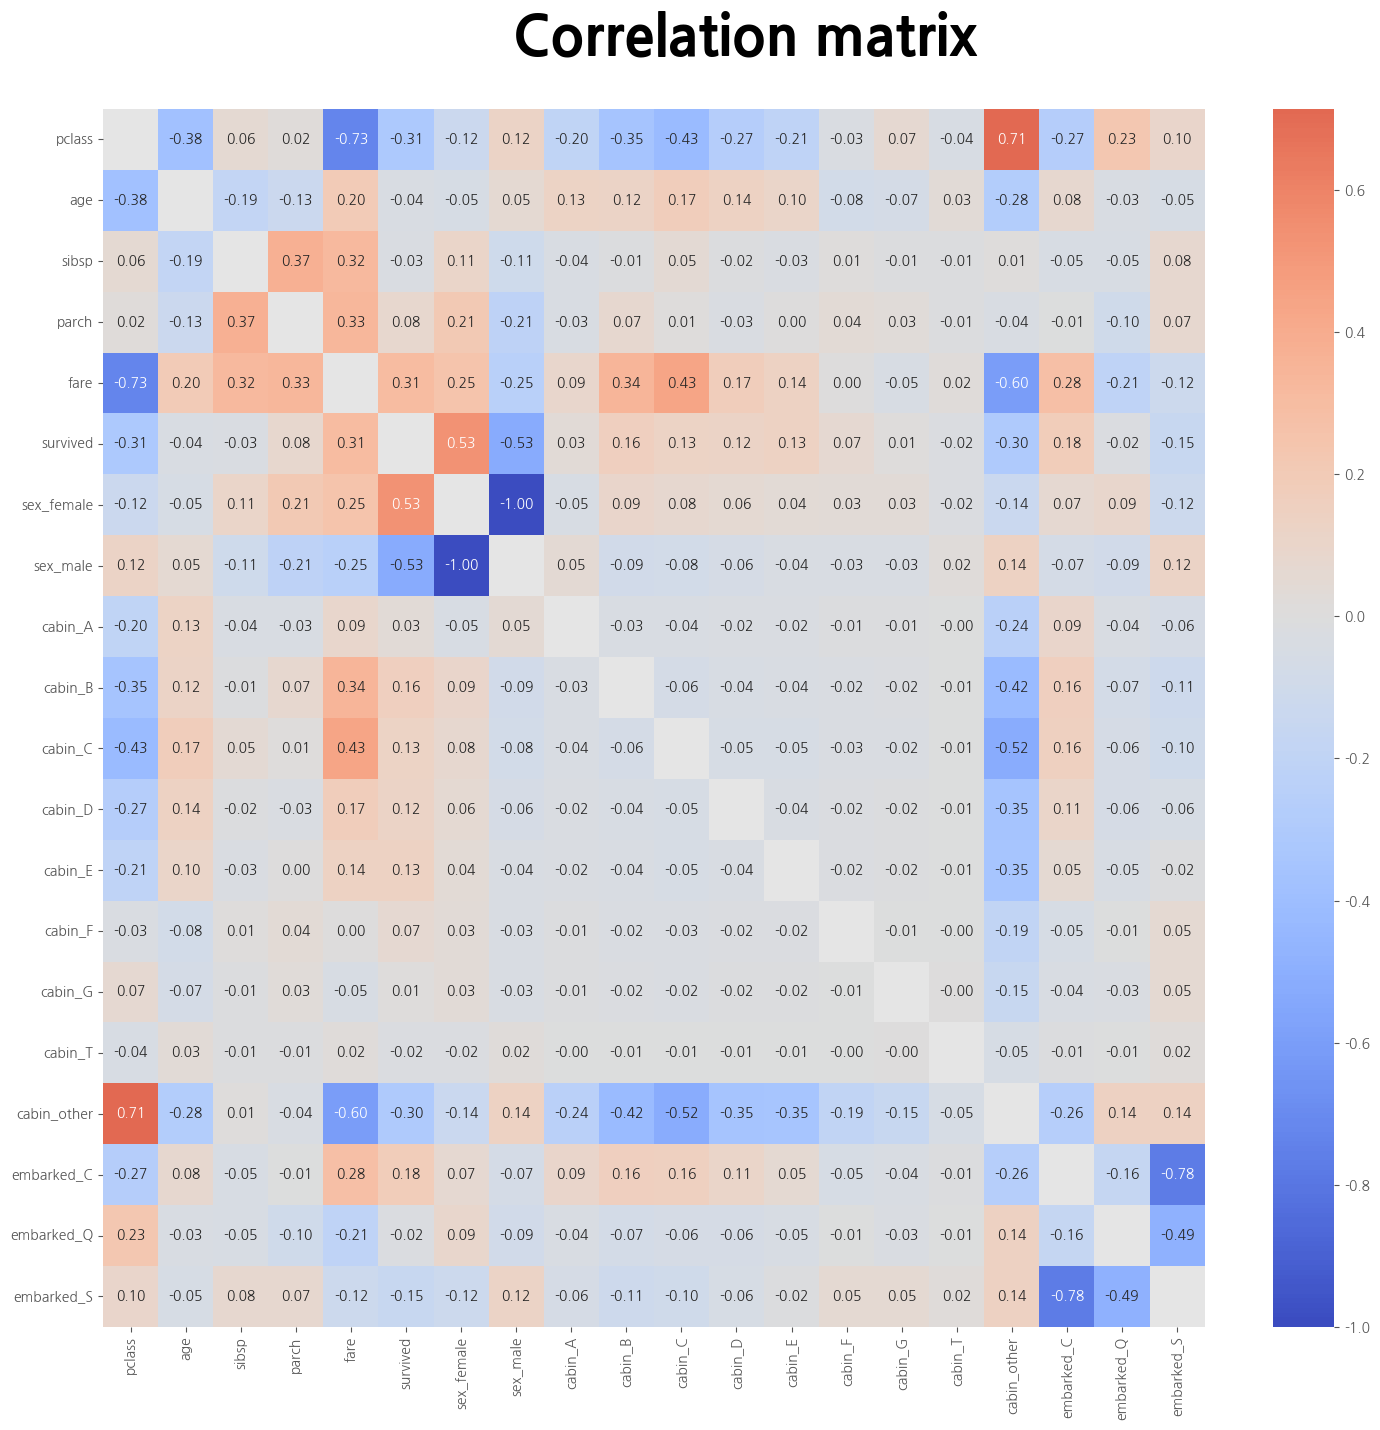

In [16]:
eda.plot_corr(data_proc.corr(), mask=False, save_dir=vis_dir)

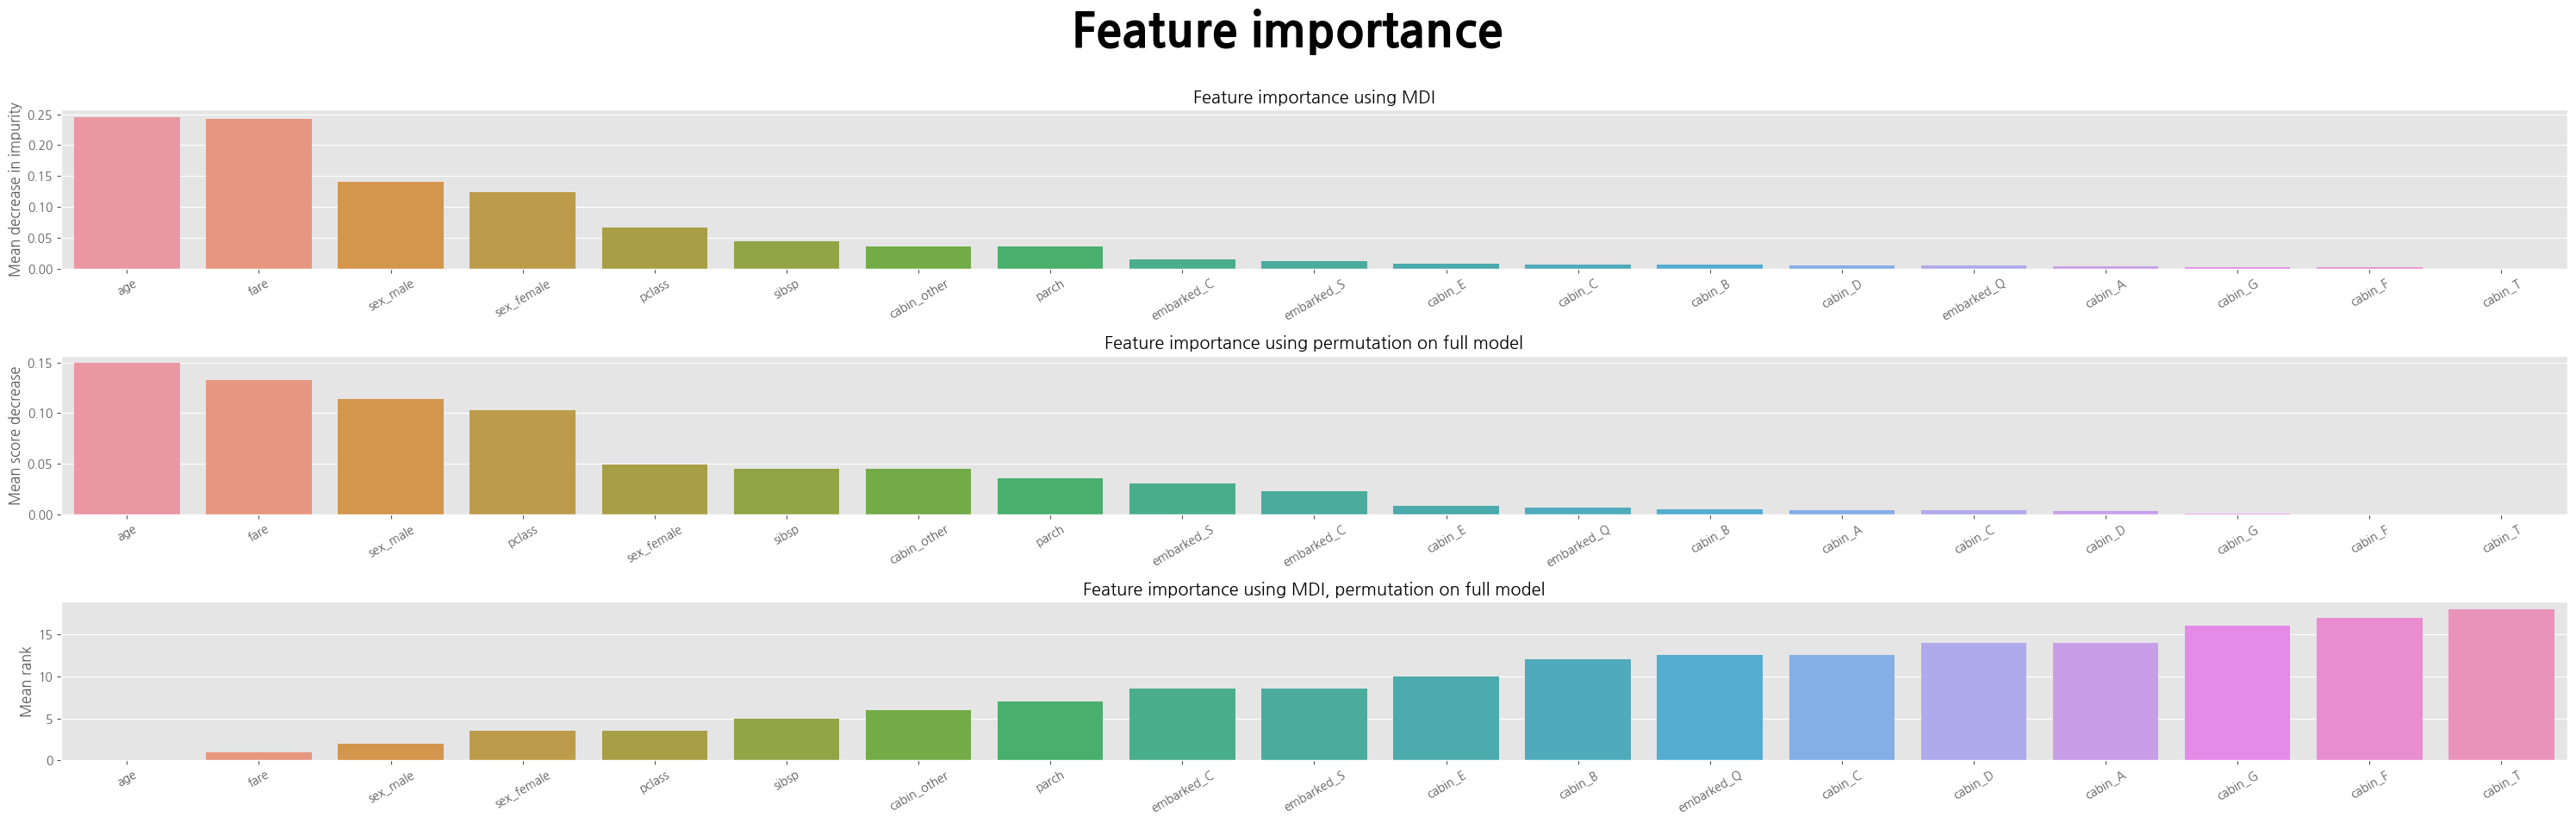

,MDI,Permutation,Mean
age,0,0,0.00
fare,1,1,1.00
sex_male,2,2,2.00
sex_female,3,4,3.50
pclass,4,3,3.50
sibsp,5,5,5.00
cabin_other,6,6,6.00
parch,7,7,7.00
embarked_S,9,8,8.50
embarked_C,8,9,8.50


In [17]:
from analysis_tools import metrics

metrics.get_feature_importance(data_proc, target, save_dir=vis_dir)